In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Install Required Libraries

!pip install -U albumentations>=0.3.0 --user 
!pip install -U --pre segmentation-models --user
!pip install dataframe_image

     |████████████████████████████████| 50 kB 8.1 MB/s 


In [ ]:
import os
os._exit(00)

In [1]:
import segmentation_models as sm

Segmentation Models: using `keras` framework.


# Loading dataset

In [2]:
import os 
import cv2
import keras
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [ ]:
!unzip /content/drive/MyDrive/ColabNotebooks/Assignment3/A3_Dataset.zip

In [3]:
y_train_path="/content/A3_Dataset/dataset1/annotations_prepped_train"
x_train_path="/content/A3_Dataset/dataset1/images_prepped_train"
y_test_path= "/content/A3_Dataset/dataset1/annotations_prepped_test"
x_test_path="/content/A3_Dataset/dataset1/images_prepped_test"

# Dataset Class  

DataLoader class code is taken from stanford dataloading file

In [31]:
# classes for data loading and preprocessing
class Dataset:
    def __init__(
            self, 
            images_dir, 
            masks_dir,  
            augmentation=None, 
            preprocessing=None,
    ):
        self.ids = os.listdir(images_dir)
        self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.ids]
        self.masks_fps = [os.path.join(masks_dir, image_id) for image_id in self.ids]
        
        self.class_values = [0,1,2,3,4,5,6,7,8,9,10,11]
        self.augmentation = augmentation
        self.preprocessing = preprocessing
    
    def __getitem__(self, i):
        
        # read data
        image = cv2.imread(self.images_fps[i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.masks_fps[i], 0)
        image =cv2.resize(image, (320,320), interpolation = cv2.INTER_AREA)
        mask=cv2.resize(mask,(320,320), interpolation = cv2.INTER_AREA)
        masks = [(mask == v) for v in self.class_values]
        mask = np.stack(masks, axis=-1).astype('float')
        
        # Augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        # Preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
            
        return image, mask
        
    def __len__(self):
        return len(self.ids)
    
    
class Dataloder(keras.utils.all_utils.Sequence):    
    def __init__(self, dataset, batch_size=1, shuffle=False):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(dataset))

        self.on_epoch_end()

    def __getitem__(self, i):
        
        # collect batch data
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        data = []
        for j in range(start, stop):
            data.append(self.dataset[j])
        
        # transpose list of lists
        batch = [np.stack(samples, axis=0) for samples in zip(*data)]
        
        return batch
    
    def __len__(self):
        """Denotes the number of batches per epoch"""
        return len(self.indexes) // self.batch_size
    
    def on_epoch_end(self):
        """Callback function to shuffle indexes each epoch"""
        if self.shuffle:
            self.indexes = np.random.permutation(self.indexes)   

**Image visualiation **

In [4]:

def visualize(sv,dest_path,model_name,**images):
    n = len(images)
    r=np.ceil(n/4)
    c=np.ceil(n/4)
    if (c==1.0):
      c=3
    plt.figure(figsize=(20, 10))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(r, c, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    if sv==1:
      plt.savefig(dest_path+model_name)
    plt.show()

def Visualize_overlay_mask(sv,dest_path,model_name,image,mask):

  #plt.figure(figsize=(25, 16))

  fig,ax =plt.subplots()
  plt.xticks([])
  plt.yticks([])
  ax.imshow(image)
  ax.imshow(mask,alpha=0.5)
  plt.title(model_name.title())
  if sv==1:
    plt.savefig(dest_path+model_name)
  plt.show()


def denormalize(x):
    x_max = np.percentile(x, 98)
    x_min = np.percentile(x, 2)    
    x = (x - x_min) / (x_max - x_min)
    x = x.clip(0, 1)
    return x
    

# classes for data loading and preprocessing
class Dataset:
    """CamVid Dataset. Read images, apply augmentation and preprocessing transformations.
    
    Args:
        images_dir (str): path to images folder
        masks_dir (str): path to segmentation masks folder
        class_values (list): values of classes to extract from segmentation mask
        augmentation (albumentations.Compose): data transfromation pipeline 
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing 
            (e.g. noralization, shape manipulation, etc.)
    
    """
    
    CLASSES = ['sky', 'building', 'pole', 'road', 'pavement', 
               'tree', 'signsymbol', 'fence', 'car', 
               'pedestrian', 'bicyclist', 'unlabelled']
    
    def __init__(
            self, 
            images_dir, 
            masks_dir, 
            classes=None, 
            augmentation=None, 
            preprocessing=None,
    ):
        self.ids = os.listdir(images_dir)
        self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.ids]
        self.masks_fps = [os.path.join(masks_dir, image_id) for image_id in self.ids]
        
        # convert str names to class values on masks
        self.class_values = [0,1,2,3,4,5,6,7,8,9,10,11]#[self.CLASSES.index(cls.lower()) for cls in classes]
        
        self.augmentation = augmentation
        self.preprocessing = preprocessing
    
    def __getitem__(self, i):
        
        # read data
        image = cv2.imread(self.images_fps[i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.masks_fps[i], 0)
        image =cv2.resize(image, (320,320), interpolation = cv2.INTER_AREA)
        mask=cv2.resize(mask,(320,320), interpolation = cv2.INTER_AREA)
        masks = [(mask == v) for v in self.class_values]
        mask = np.stack(masks, axis=-1).astype('float')
        
        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
            
        return image, mask
        
    def __len__(self):
        return len(self.ids)


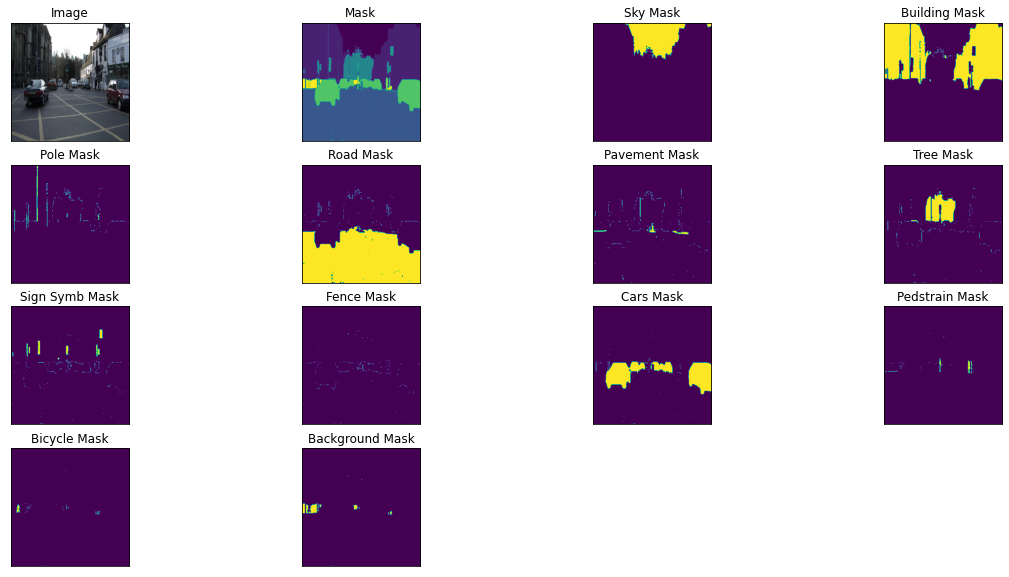

In [22]:

dataset = Dataset(x_train_path, y_train_path)

image, mask = dataset[100] # get some sample
Gt_mask=np.argmax(mask.squeeze(),axis=-1)
dest_path='/content/drive/MyDrive/'
model_name='dataset'
visualize(1,dest_path,model_name,
    image=image, 
    mask=Gt_mask,
    sky_mask=mask[..., 0].squeeze(),
    Building_mask=mask[..., 1].squeeze(),
    Pole_mask=mask[..., 2].squeeze(),
    Road_mask=mask[..., 3].squeeze(),
    Pavement_mask=mask[..., 4].squeeze(),
    Tree_mask=mask[..., 5].squeeze(),
    sign_symb_mask=mask[..., 6].squeeze(),
    Fence_mask=mask[..., 7].squeeze(),
    cars_mask=mask[..., 8].squeeze(),
    Pedstrain_mask=mask[..., 9].squeeze(),
    Bicycle_mask=mask[..., 10].squeeze(),
    Background_mask=mask[..., 11].squeeze()

)

### Augmentations

In [5]:
import albumentations as A

In [23]:
def round_clip_0_1(x, **kwargs):
    return x.round().clip(0, 1)

def get_training_augmentation():
    train_transform = [

        A.HorizontalFlip(p=0.5),

        A.ShiftScaleRotate(scale_limit=0.5, rotate_limit=0, shift_limit=0.1, p=1, border_mode=0),

        A.PadIfNeeded(min_height=320, min_width=320, always_apply=True, border_mode=0),
        A.RandomCrop(height=320, width=320, always_apply=True),

        A.IAAAdditiveGaussianNoise(p=0.2),
        A.IAAPerspective(p=0.5),

        A.OneOf(
            [
                A.CLAHE(p=1),
                A.RandomBrightness(p=1),
                A.RandomGamma(p=1),
            ],
            p=0.9,
        ),

        A.OneOf(
            [
                A.IAASharpen(p=1),
                A.Blur(blur_limit=3, p=1),
                A.MotionBlur(blur_limit=3, p=1),
            ],
            p=0.9,
        ),

        A.OneOf(
            [
                A.RandomContrast(p=1),
                A.HueSaturationValue(p=1),
            ],
            p=0.9,
        ),
        A.Lambda(mask=round_clip_0_1)
    ]
    return A.Compose(train_transform)


def get_validation_augmentation():
    test_transform = [
        A.PadIfNeeded(320, 320)
    ]
    return A.Compose(test_transform)

def get_preprocessing(preprocessing_fn):
    _transform = [
        A.Lambda(image=preprocessing_fn),
    ]
    return A.Compose(_transform)

/root/.local/lib/python3.7/site-packages/albumentations/imgaug/transforms.py:252: FutureWarning: IAAAdditiveGaussianNoise is deprecated. Please use GaussNoise instead
  warnings.warn("IAAAdditiveGaussianNoise is deprecated. Please use GaussNoise instead", FutureWarning)
/root/.local/lib/python3.7/site-packages/albumentations/imgaug/transforms.py:375: FutureWarning: This IAAPerspective is deprecated. Please use Perspective instead
  warnings.warn("This IAAPerspective is deprecated. Please use Perspective instead", FutureWarning)
/root/.local/lib/python3.7/site-packages/albumentations/augmentations/transforms.py:1802: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  FutureWarning,
/root/.local/lib/python3.7/site-packages/albumentations/imgaug/transforms.py:222: FutureWarning: IAASharpen is deprecated. Please use Sharpen instead
  warnings.warn("IAASharpen is deprecated. Please use Sharpen instead", FutureWarning)
/root/.local/lib/python3.7/site-package

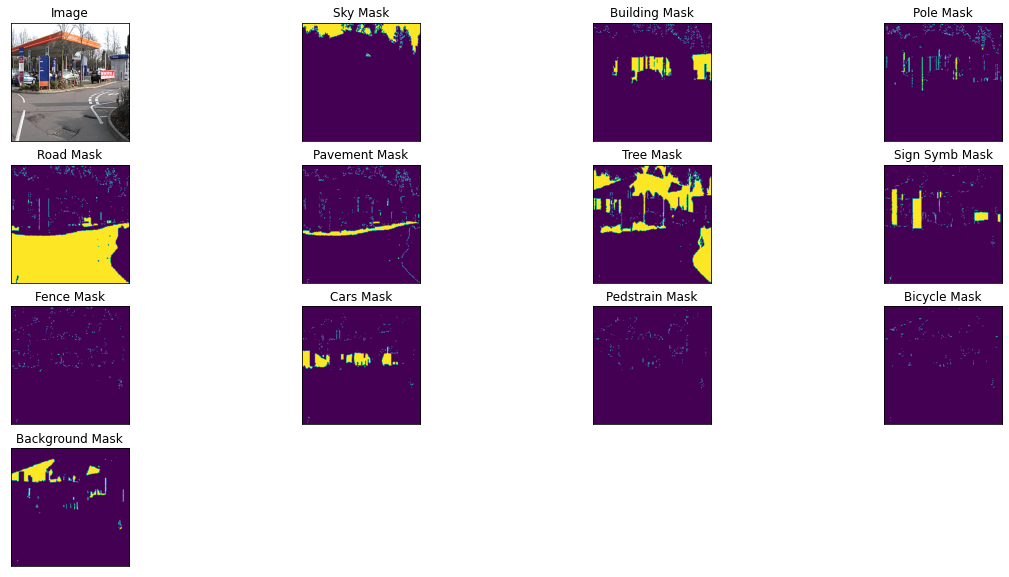

In [24]:
dataset = Dataset(x_train_path, y_train_path, augmentation=get_training_augmentation())

image, mask = dataset[350] # get some sample
visualize(0,0,0,
    image=image, 
    sky_mask=mask[..., 0].squeeze(),
    Building_mask=mask[..., 1].squeeze(),
    Pole_mask=mask[..., 2].squeeze(),
    Road_mask=mask[..., 3].squeeze(),
    Pavement_mask=mask[..., 4].squeeze(),
    Tree_mask=mask[..., 5].squeeze(),
    sign_symb_mask=mask[..., 6].squeeze(),
    Fence_mask=mask[..., 7].squeeze(),
    cars_mask=mask[..., 8].squeeze(),
    Pedstrain_mask=mask[..., 9].squeeze(),
    Bicycle_mask=mask[..., 10].squeeze(),
    Background_mask=mask[..., 11].squeeze()

)

# Model 

In [7]:
#import segmentation_models as sm
import tensorflow as tf
SM_FRAMEWORK=tf.keras
import segmentation_models as sm
sm.set_framework('tf.keras')


In [26]:
# network parameters
BACKBONE = 'densenet121'
BATCH_SIZE = 8
LR = 0.001
EPOCHS = 100
preprocess_input = sm.get_preprocessing(BACKBONE)
n_classes = 12
activation =  'softmax'

model=sm.Unet(BACKBONE, input_shape=(320,320,3),classes=n_classes, activation=activation,encoder_freeze=True)

In [27]:
# custom metrics 
import keras.backend as K
def dice_coef(y_true, y_pred, smooth=1):
  intersection = K.sum(y_true * y_pred, axis=[1,2,3])
  union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3])
  dice = K.mean((2. * intersection + smooth)/(union + smooth), axis=0)
  return dice
def sensitivity(y_true, y_pred): 
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())
def specificity(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1 - y_true) * (1 - y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1 - y_true, 0, 1)))
    return true_negatives / (possible_negatives + K.epsilon())

In [29]:
# training settings
optim = tf.keras.optimizers.Adam(LR)
loss = sm.losses.categorical_focal_dice_loss 
#loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True)
metrics = [dice_coef,sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5),'accuracy',sensitivity,specificity]
#metrics=[tf.keras.metrics.Accuracy()]
# compile keras model with defined optimozer, loss and metrics
model.compile(optim, loss, metrics)

In [30]:
# Dataset for train images
train_dataset = Dataset(
    x_train_path, 
    y_train_path, 
    augmentation=get_training_augmentation(),
    preprocessing=get_preprocessing(preprocess_input),
)
train_X, val_X = train_test_split(train_dataset,test_size=0.2, random_state=0 )
train_dataloader = Dataloder(train_X, batch_size=BATCH_SIZE, shuffle=True)
valid_dataloader = Dataloder(val_X, batch_size=1, shuffle=False)
file_path='/content/drive/MyDrive/ColabNotebooks/Assignment3/results/'
callbacks = [
    keras.callbacks.ModelCheckpoint(file_path+'resnet0_fine_best_model.epoch{epoch:02d}-loss{val_loss:.2f}.hdf5', save_best_only=True, mode='min'),
    keras.callbacks.ReduceLROnPlateau(),
    keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, mode='min',min_delta=0.001)]

/root/.local/lib/python3.7/site-packages/albumentations/imgaug/transforms.py:252: FutureWarning: IAAAdditiveGaussianNoise is deprecated. Please use GaussNoise instead
  warnings.warn("IAAAdditiveGaussianNoise is deprecated. Please use GaussNoise instead", FutureWarning)
/root/.local/lib/python3.7/site-packages/albumentations/imgaug/transforms.py:375: FutureWarning: This IAAPerspective is deprecated. Please use Perspective instead
  warnings.warn("This IAAPerspective is deprecated. Please use Perspective instead", FutureWarning)
/root/.local/lib/python3.7/site-packages/albumentations/augmentations/transforms.py:1802: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  FutureWarning,
/root/.local/lib/python3.7/site-packages/albumentations/imgaug/transforms.py:222: FutureWarning: IAASharpen is deprecated. Please use Sharpen instead
  warnings.warn("IAASharpen is deprecated. Please use Sharpen instead", FutureWarning)
/root/.local/lib/python3.7/site-package

In [33]:
# train model
history = model.fit_generator(
    train_dataloader, 
    steps_per_epoch=len(train_dataloader), 
    epochs=10, 
    callbacks=callbacks, 
    validation_data=valid_dataloader, 
    validation_steps=len(valid_dataloader),
)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


Epoch 1/10
36/36 [==============================] - 16s 457ms/step - loss: 0.5414 - dice_coef: 0.7088 - iou_score: 0.3976 - f1-score: 0.4697 - accuracy: 0.6712 - sensitivity: 0.8142 - specificity: 0.9757 - val_loss: 0.7024 - val_dice_coef: 0.6300 - val_iou_score: 0.2717 - val_f1-score: 0.3276 - val_accuracy: 0.6045 - val_sensitivity: 0.7118 - val_specificity: 0.9717 - lr: 0.0010
Epoch 2/10
36/36 [==============================] - 16s 441ms/step - loss: 0.5165 - dice_coef: 0.7104 - iou_score: 0.4191 - f1-score: 0.5066 - accuracy: 0.6692 - sensitivity: 0.8193 - specificity: 0.9719 - val_loss: 0.6899 - val_dice_coef: 0.6443 - val_iou_score: 0.2745 - val_f1-score: 0.3397 - val_accuracy: 0.6093 - val_sensitivity: 0.7253 - val_specificity: 0.9676 - lr: 0.0010
Epoch 3/10
36/36 [==============================] - 15s 426ms/step - loss: 0.4913 - dice_coef: 0.7224 - iou_score: 0.4395 - f1-score: 0.5318 - accuracy: 0.6793 - sensitivity: 0.8327 - specificity: 0.9723 - val_loss: 0.6502 - val_dice_co

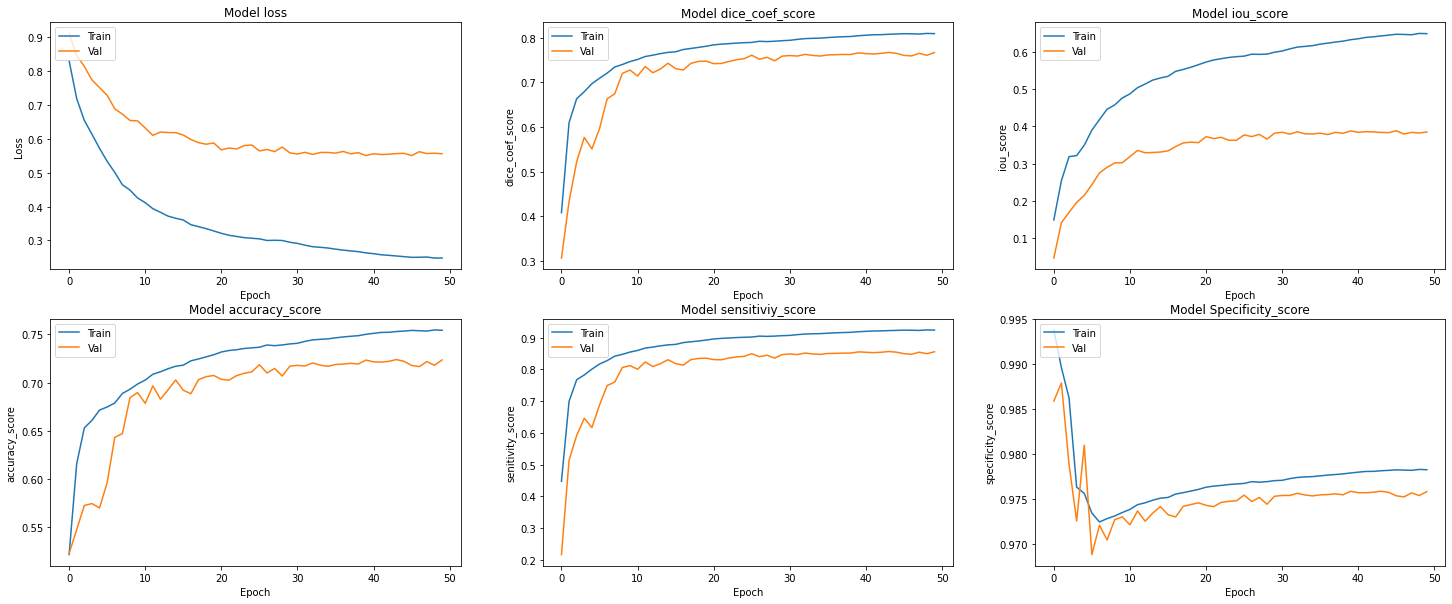

In [21]:
# Plot training & validation iou_score values
plt.figure(figsize=(25, 10))


#Plot training & validation loss values
plt.subplot(231)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
#plt.plot( np.argmin(model.history.history['val_loss']), np.min(model.history.history['val_loss']), marker="x", color="r", label="best model")
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')


plt.subplot(232)
plt.plot(history.history['dice_coef'])
plt.plot(history.history['val_dice_coef'])
plt.title('Model dice_coef_score')
plt.ylabel('dice_coef_score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')

plt.subplot(233)
plt.plot(history.history['iou_score'])
plt.plot(history.history['val_iou_score'])
plt.title('Model iou_score')
plt.ylabel('iou_score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
#

plt.subplot(234)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy_score')
plt.ylabel('accuracy_score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
#

plt.subplot(235)
plt.plot(history.history['sensitivity'])
plt.plot(history.history['val_sensitivity'])
plt.title('Model sensitiviy_score')
plt.ylabel('senitivity_score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')

plt.subplot(236)
plt.plot(history.history['specificity'])
plt.plot(history.history['val_specificity'])
plt.title('Model Specificity_score')
plt.ylabel('specificity_score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.savefig(file_path+'aug_densenet_trans_loss')
plt.show()


# Model Evaluation

In [34]:
test_dataset = Dataset(
    x_test_path, 
    y_test_path, 
    augmentation=get_validation_augmentation(),
    preprocessing=get_preprocessing(preprocess_input),
)

test_dataloader = Dataloder(test_dataset, batch_size=1, shuffle=False)

In [35]:
# load best weights

path_to_weights='/content/drive/MyDrive/ColabNotebooks/Assignment3/results/densenet_freeze_aug_best_model.epoch37-loss0.54.hdf5'
model.load_weights(path_to_weights) 

# Results on test dataset

In [37]:
scores = model.evaluate_generator(test_dataloader)
import pandas as pd
import dataframe_image as dfi
s = pd.Series({'Model': 'Densenet121 with Augmenatation', 
               'CFD-Loss': scores[0], 
               'dice-coeff': scores[1],
               'IOU score':scores[2],
               'F1-Score':scores[3],
               'Accuracy':scores[4],
               'Sensitivity':scores[5],
               'Specificity':scores[6]})
df=pd.DataFrame(s)
df_styled = df.style.background_gradient()
df.set_axis(['values'], axis=1, inplace=True)
dfi.export(df_styled,"aug-densenet-freeze.png",table_conversion="matplotlib")
df.head(8)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  """Entry point for launching an IPython kernel.


,values
Model,Densenet121 with Augmenatation
CFD-Loss,0.345451
dice-coeff,0.898837
IOU score,0.57472
F1-Score,0.67237
Accuracy,0.901039
Sensitivity,0.899953
Specificity,0.99128


[62 13 50 40]


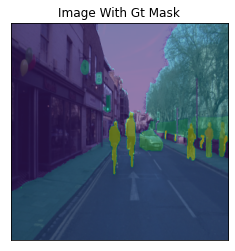

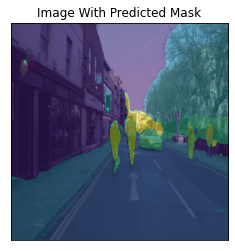

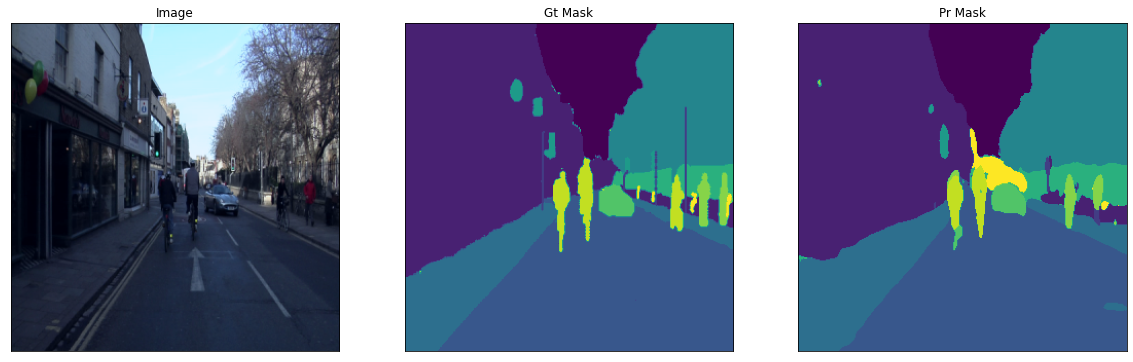

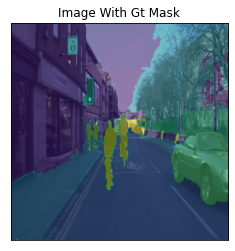

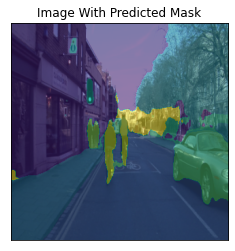

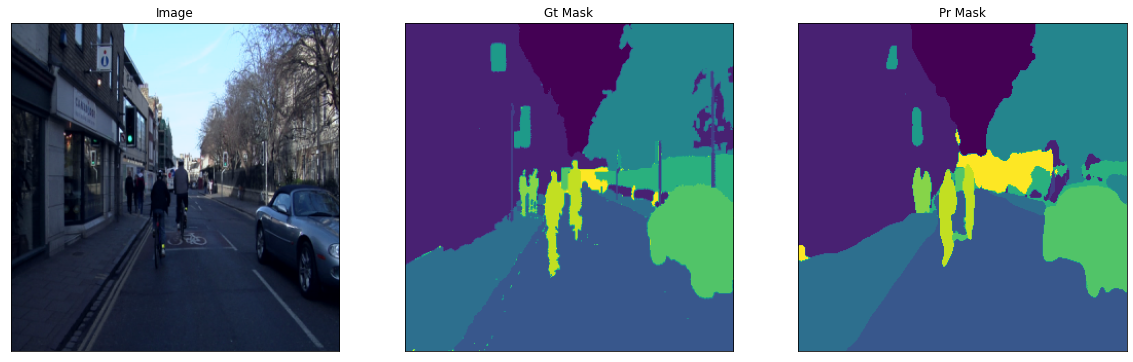

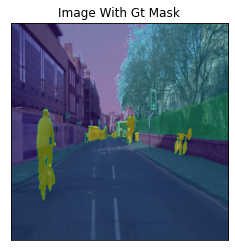

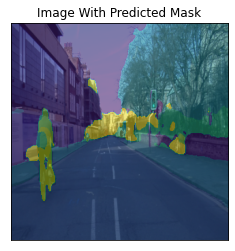

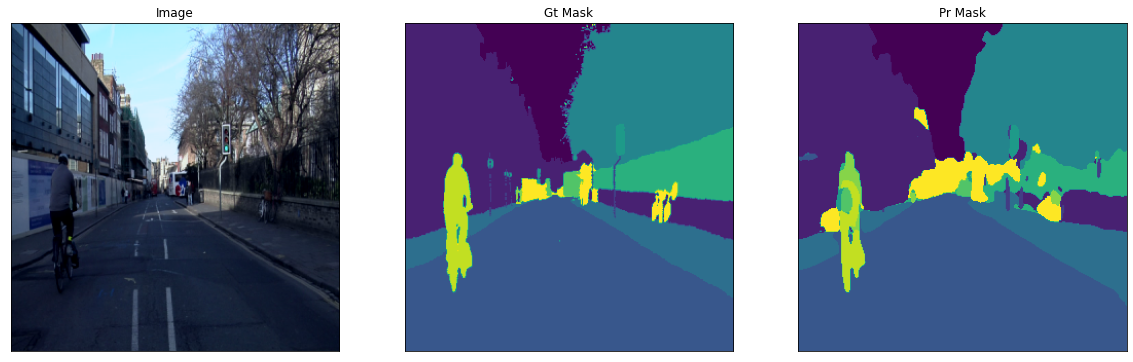

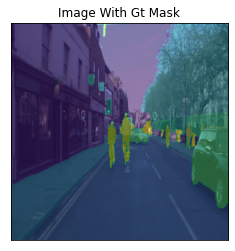

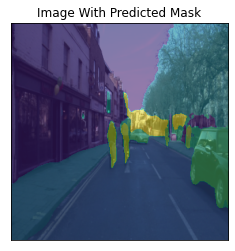

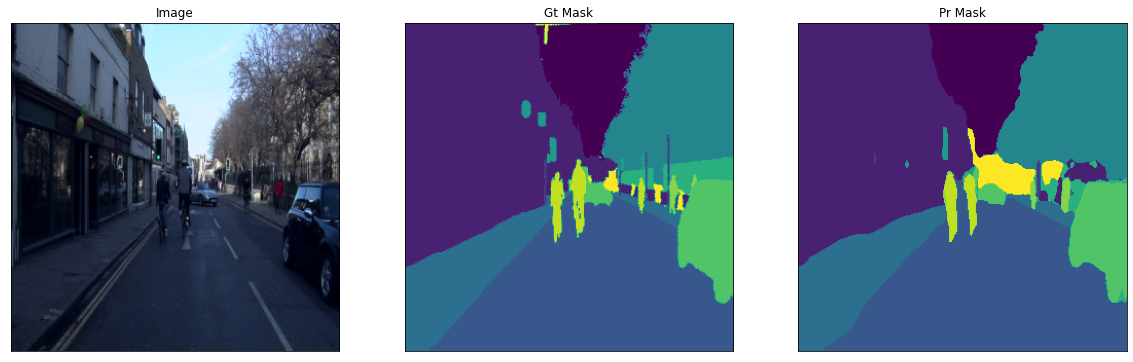

In [36]:
n = 4
ids = np.random.choice(np.arange(len(test_dataset)), size=n)
print(ids)

for i in ids:
    
    image, gt_mask = test_dataset[i]
    image = np.expand_dims(image, axis=0)
    pr_mask = model.predict(image)
    Gt_mask=np.argmax(gt_mask.squeeze(),axis=-1)
    Pr_mask=np.argmax(pr_mask.squeeze(),axis=-1)
    Visualize_overlay_mask(1,file_path,'Image with GT mask',
      image=denormalize(image.squeeze()),
      mask=Gt_mask)
    Visualize_overlay_mask(1,file_path,'Image with predicted mask',
        image=denormalize(image.squeeze()),
        mask=Pr_mask)
    visualize(1,file_path,'VGG16-CFD',
        image=denormalize(image.squeeze()),
        GT_mask=Gt_mask,
        Pr_mask=Pr_mask
      
    )